In [2]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch,autogluon

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.27.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.9.2
sklearn   : 1.5.2
pandas    : 2.1.4
torch     : 2.3.0
autogluon : 1.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



### Loading Model , Libraries and Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# load model using pytorch from models folder
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(4, 16)  # Hidden layer with 16 neurons
        self.output = nn.Linear(16, 3)  # Output layer (3 classes)

    def forward(self, x):
        x = torch.relu(self.hidden(x))  # ReLU activation
        x = self.output(x) # no softmax here since we'll use nn.CrossEntropyLoss 
        return x 
    
# Initialize the model
model = MLP()
print(model)

MLP(
  (hidden): Linear(in_features=4, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)


In [5]:
from torch.utils.data import DataLoader

# Load datasets

train_dataset = torch.load('data/train_dataset.pt')
val_dataset = torch.load('data/val_dataset.pt')
test_dataset = torch.load('data/test_dataset.pt')

In [6]:
def tensor_to_dataframe(tensor_dataset, feature_names=None, target_name='target'):
    """Convert PyTorch TensorDataset to Pandas DataFrame."""
    X_tensor, y_tensor = tensor_dataset.tensors
    X = X_tensor.numpy()
    y = y_tensor.numpy()

    feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

    df = pd.DataFrame(X, columns=feature_names)
    df[target_name] = y  # Add target column

    return df

# Convert PyTorch datasets to Pandas DataFrames
train_df = tensor_to_dataframe(train_dataset)
val_df = tensor_to_dataframe(val_dataset)
test_df = tensor_to_dataframe(test_dataset)

# Display the first few rows of the training set
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.293480,-0.539023,0.639396,1.052636,2
1,1.000297,-0.078881,0.809938,1.449739,2
2,-1.116793,-1.229235,0.412007,0.655534,2
3,1.000297,0.151189,0.355160,0.258432,1
4,-0.999177,1.071472,-1.407104,-1.197610,0


In [7]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-1.704873,-0.078881,-1.407104,-1.329978,0
1,0.294600,-0.078881,0.639396,0.787901,2
2,-1.116793,-1.459306,-0.270160,-0.271038,1
3,-0.999177,-1.689376,-0.270160,-0.271038,1
4,-1.704873,0.381260,-1.407104,-1.329978,0


### Autogluon

Autogluon is an open-source machine learning (ML) library that automates the ML process. It was developed by Amazon Web Services (AWS). 

In [8]:
%pip install autogluon -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

### Manual Mode

In [10]:
import autogluon.core as ag

def train_manual_mode(train_data, batch_size, learning_rate, num_epochs):
    """Train model using manual hyperparameters in AutoGluon."""
    
    nn_options = {
        'num_epochs': num_epochs,  
        'learning_rate': learning_rate,    
        'batch_size': batch_size,  
        'hidden_size': 16,  
        'num_layers': 2,  
        'activation': 'relu'
    }
    
    hyperparameters = {
        'NN_TORCH': nn_options
    }
    
    model_path = f'models/manual_training/bs{batch_size}_lr{learning_rate}_epochs{num_epochs}'
    
    predictor = TabularPredictor(
        label='target',  
        problem_type='multiclass',
        verbosity=1,
        eval_metric='accuracy',  
        path=model_path,
    ).fit(
        train_data=train_data,
        hyperparameters=hyperparameters,
        time_limit=600,
        presets='best_quality',
    )
    
    return predictor

In [11]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from autogluon.common import space

def evaluate_model(predictor, test_data):
    """Evaluate the trained model on test data."""
    print("Evaluating model...")
    y_pred = predictor.predict(test_data.drop(columns=['target']))  
    y_true = test_data['target']

    accuracy = (y_pred == y_true).mean()
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}\n")
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predictor.class_labels, yticklabels=predictor.class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Print classification report
    print(classification_report(y_true, y_pred))
    
    # Show 5 sample predictions
    sample_indices = [1, 5, 10, 15, 20]
    for i in sample_indices:
        print(f"Sample {i}: Truth: {y_true.iloc[i]}, Predicted: {y_pred.iloc[i]}")
    
    print('-'*50)
    
    return accuracy, f1

Model already trained with Batch Size: 2, Learning Rate: 0.001, Epochs: 1
Evaluating model...
Accuracy: 0.7333, F1 Score: 0.6936



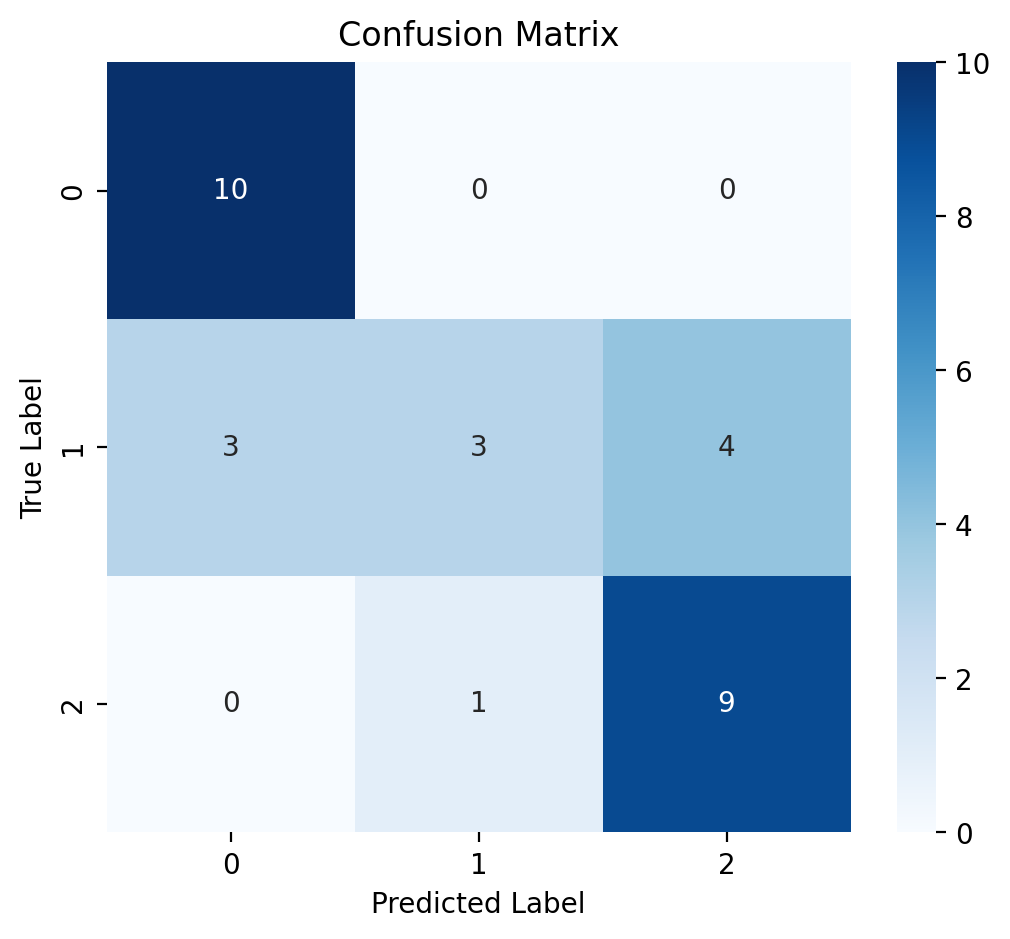

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.75      0.30      0.43        10
           2       0.69      0.90      0.78        10

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.69        30
weighted avg       0.74      0.73      0.69        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 2, Learning Rate: 0.001, Epochs: 3
Evaluating model...
Accuracy: 0.7000, F1 Score: 0.6105



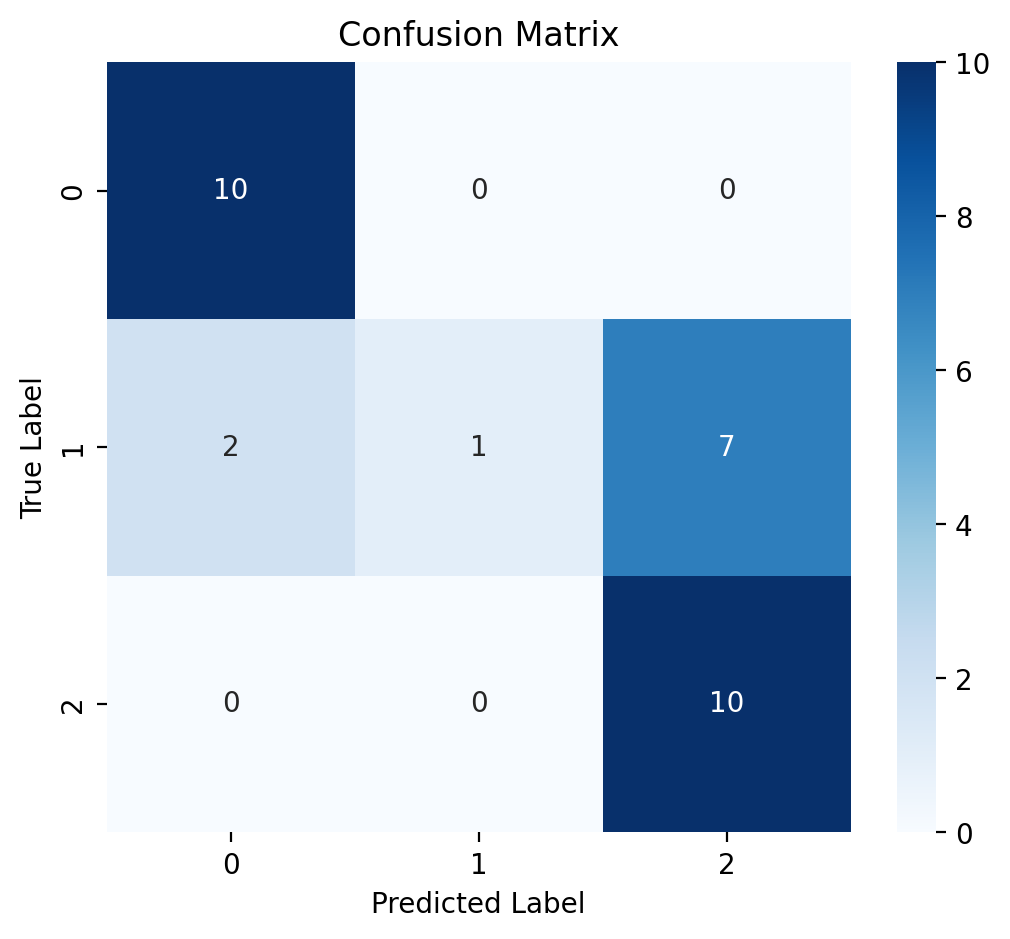

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.10      0.18        10
           2       0.59      1.00      0.74        10

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.61        30
weighted avg       0.81      0.70      0.61        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 2, Learning Rate: 0.001, Epochs: 5
Evaluating model...
Accuracy: 0.7667, F1 Score: 0.7341



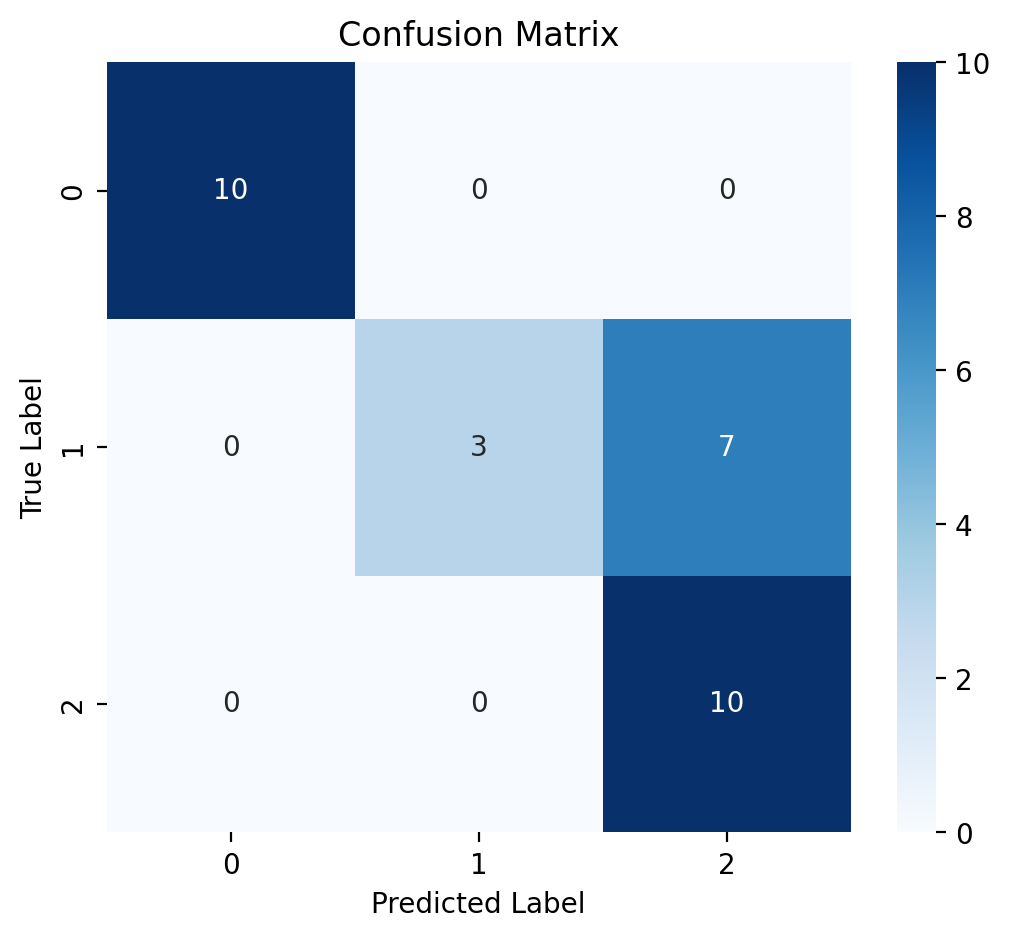

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.30      0.46        10
           2       0.59      1.00      0.74        10

    accuracy                           0.77        30
   macro avg       0.86      0.77      0.73        30
weighted avg       0.86      0.77      0.73        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 2, Learning Rate: 1e-05, Epochs: 1
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



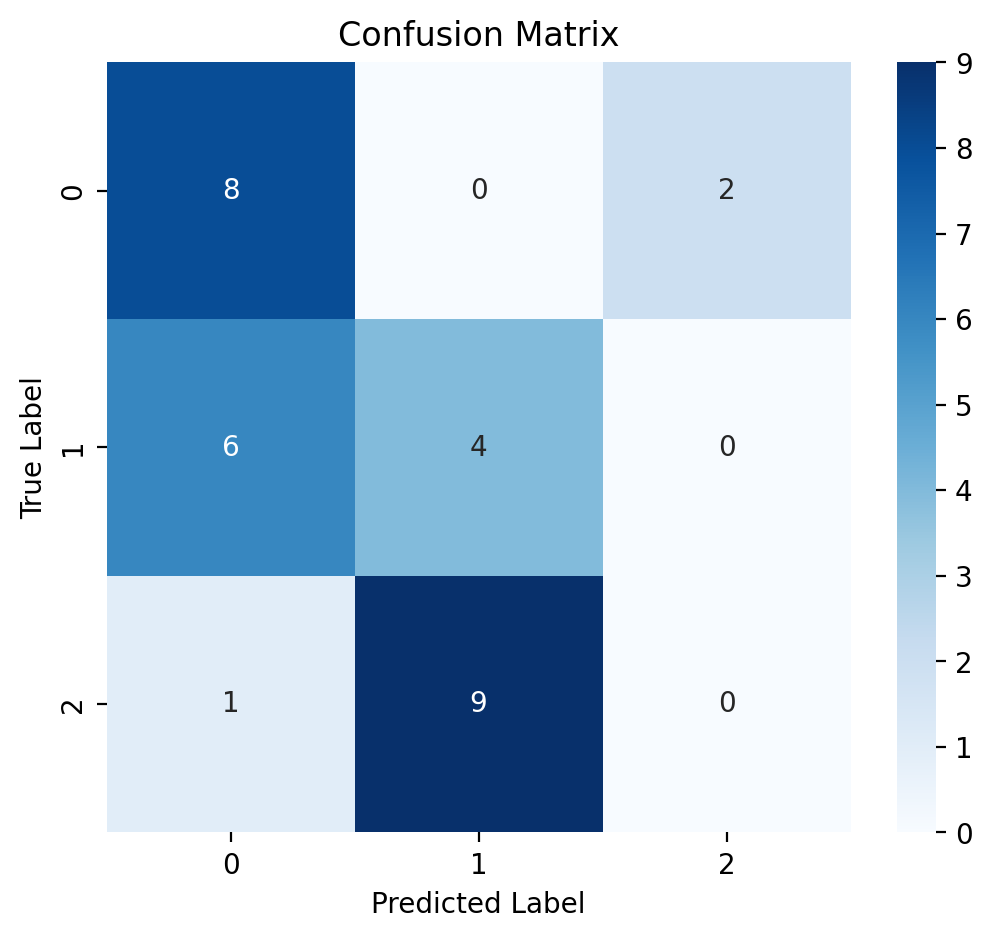

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 2, Learning Rate: 1e-05, Epochs: 3
Evaluating model...
Accuracy: 0.5667, F1 Score: 0.4556



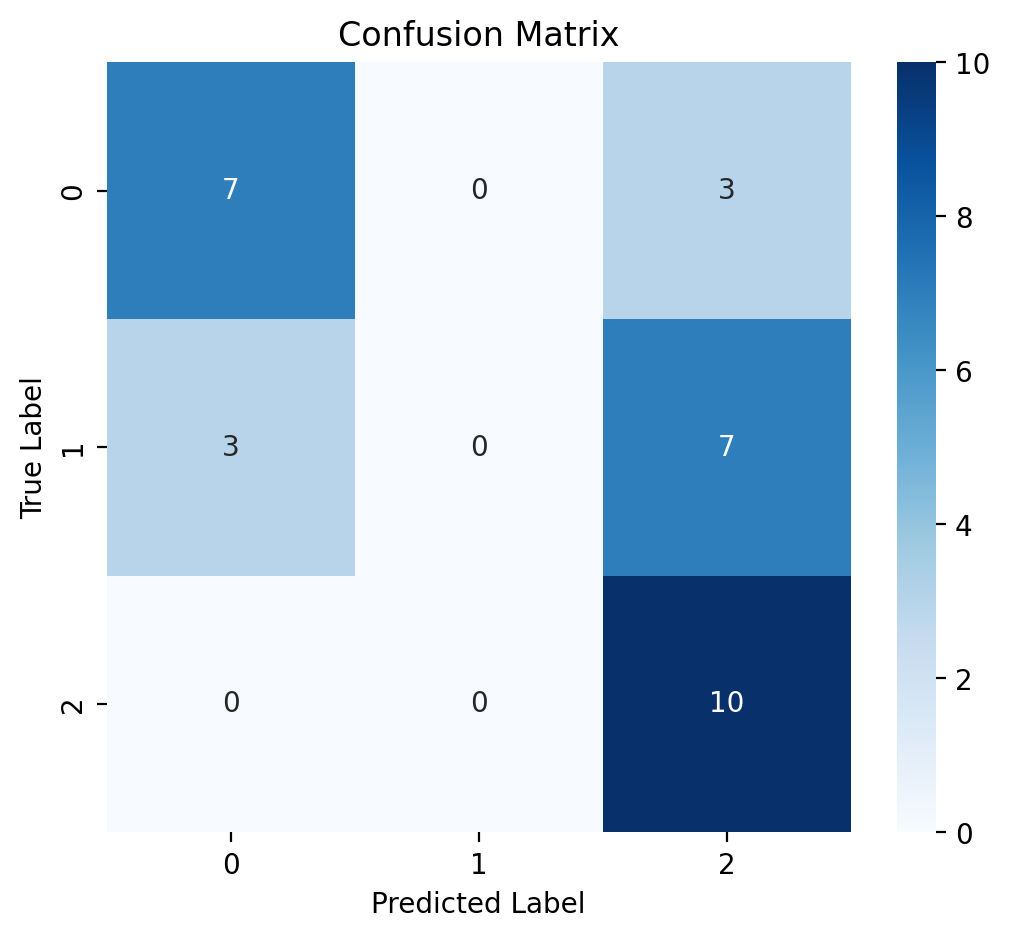

c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.00      0.00      0.00        10
           2       0.50      1.00      0.67        10

    accuracy                           0.57        30
   macro avg       0.40      0.57      0.46        30
weighted avg       0.40      0.57      0.46        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 2
--------------------------------------------------
Model already trained with Batch Size: 2, Learning Rate: 1e-05, Epochs: 5
Evaluating model...
Accuracy: 0.5667, F1 Score: 0.4556



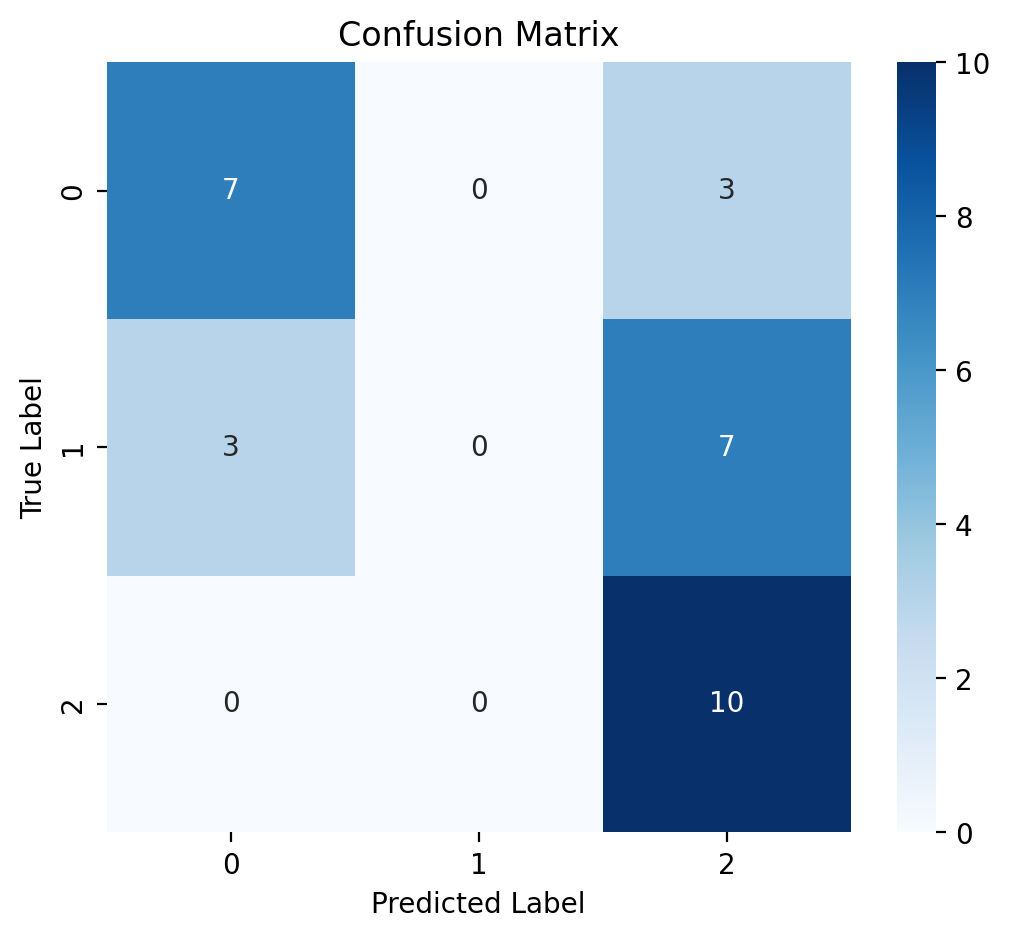

c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.00      0.00      0.00        10
           2       0.50      1.00      0.67        10

    accuracy                           0.57        30
   macro avg       0.40      0.57      0.46        30
weighted avg       0.40      0.57      0.46        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 2
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 0.001, Epochs: 1
Evaluating model...
Accuracy: 0.5333, F1 Score: 0.5000



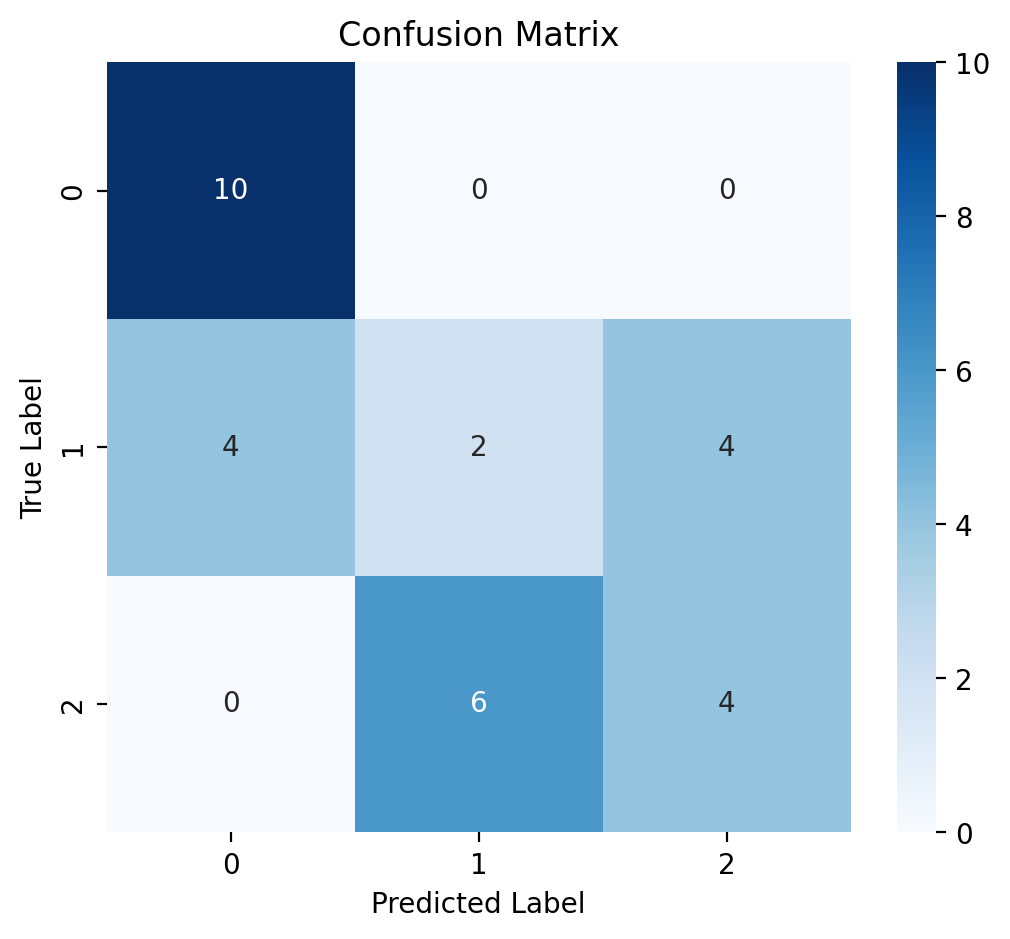

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.25      0.20      0.22        10
           2       0.50      0.40      0.44        10

    accuracy                           0.53        30
   macro avg       0.49      0.53      0.50        30
weighted avg       0.49      0.53      0.50        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 0.001, Epochs: 3
Evaluating model...
Accuracy: 0.6667, F1 Score: 0.5854



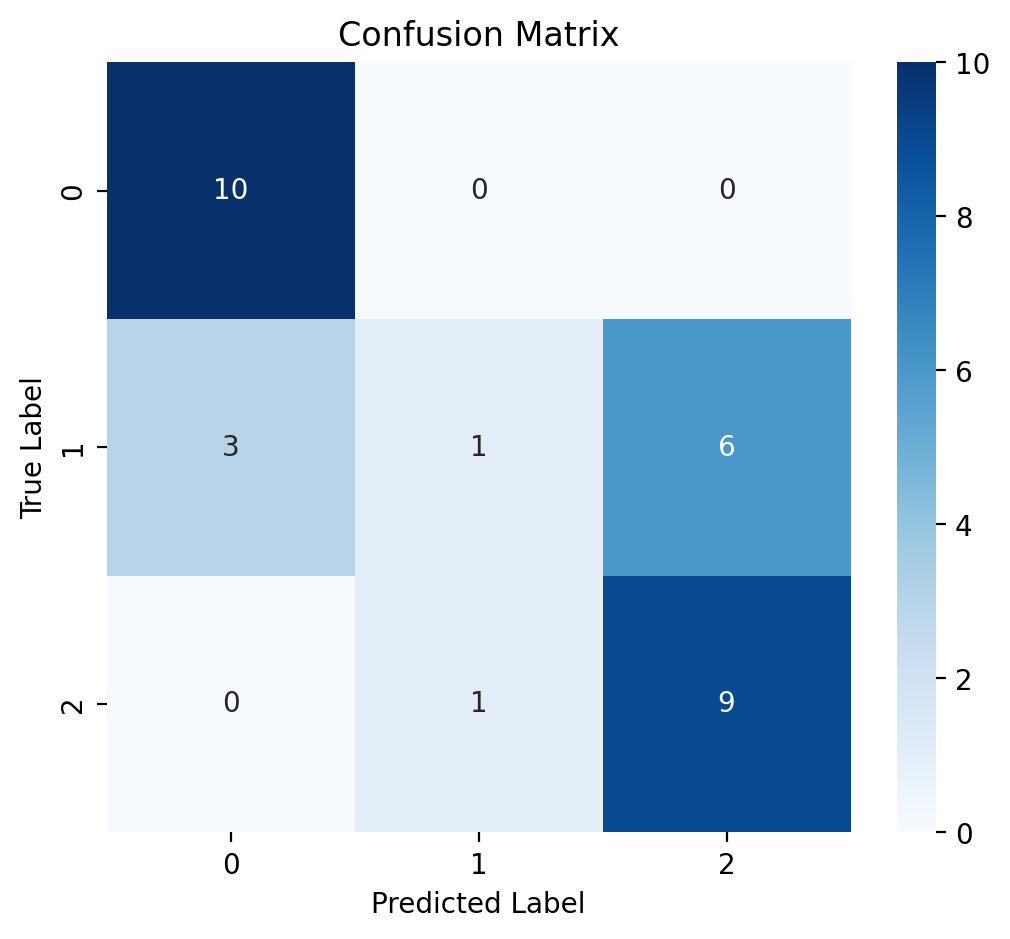

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.50      0.10      0.17        10
           2       0.60      0.90      0.72        10

    accuracy                           0.67        30
   macro avg       0.62      0.67      0.59        30
weighted avg       0.62      0.67      0.59        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 0.001, Epochs: 5
Evaluating model...
Accuracy: 0.7000, F1 Score: 0.6105



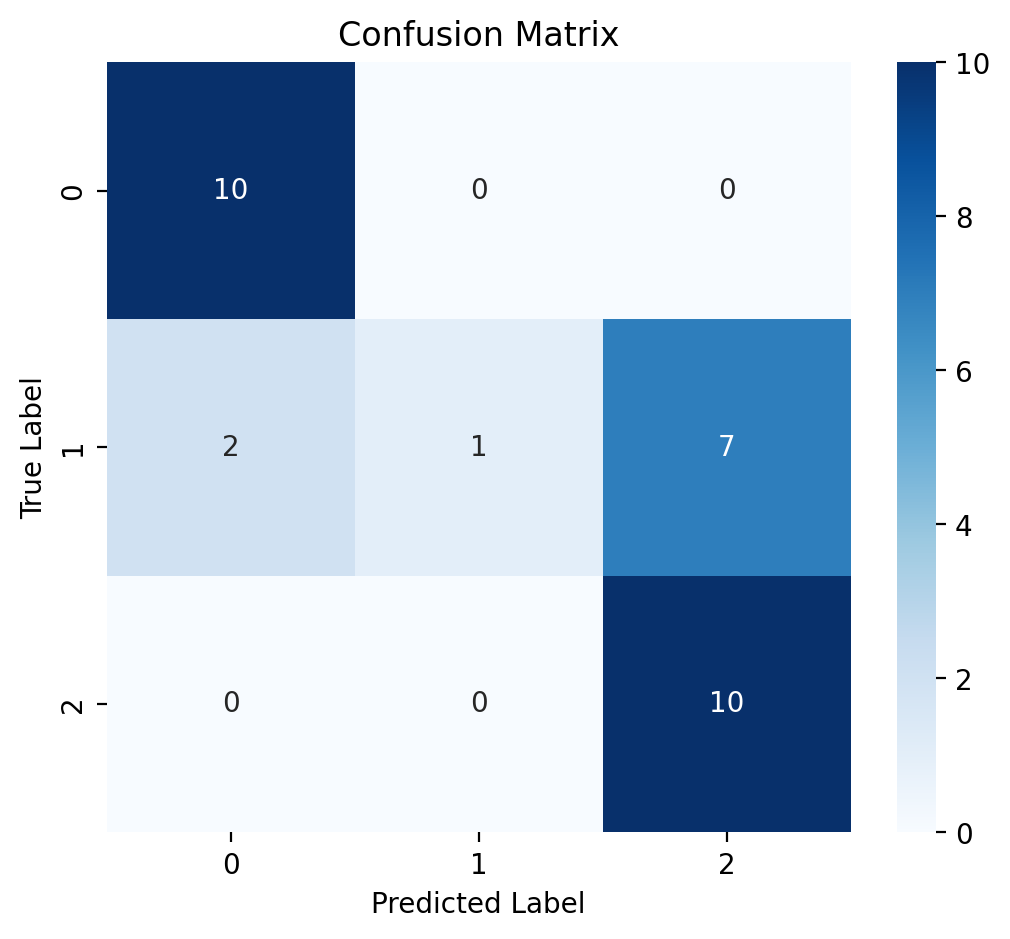

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.10      0.18        10
           2       0.59      1.00      0.74        10

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.61        30
weighted avg       0.81      0.70      0.61        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 1e-05, Epochs: 1
Evaluating model...
Accuracy: 0.5667, F1 Score: 0.4556



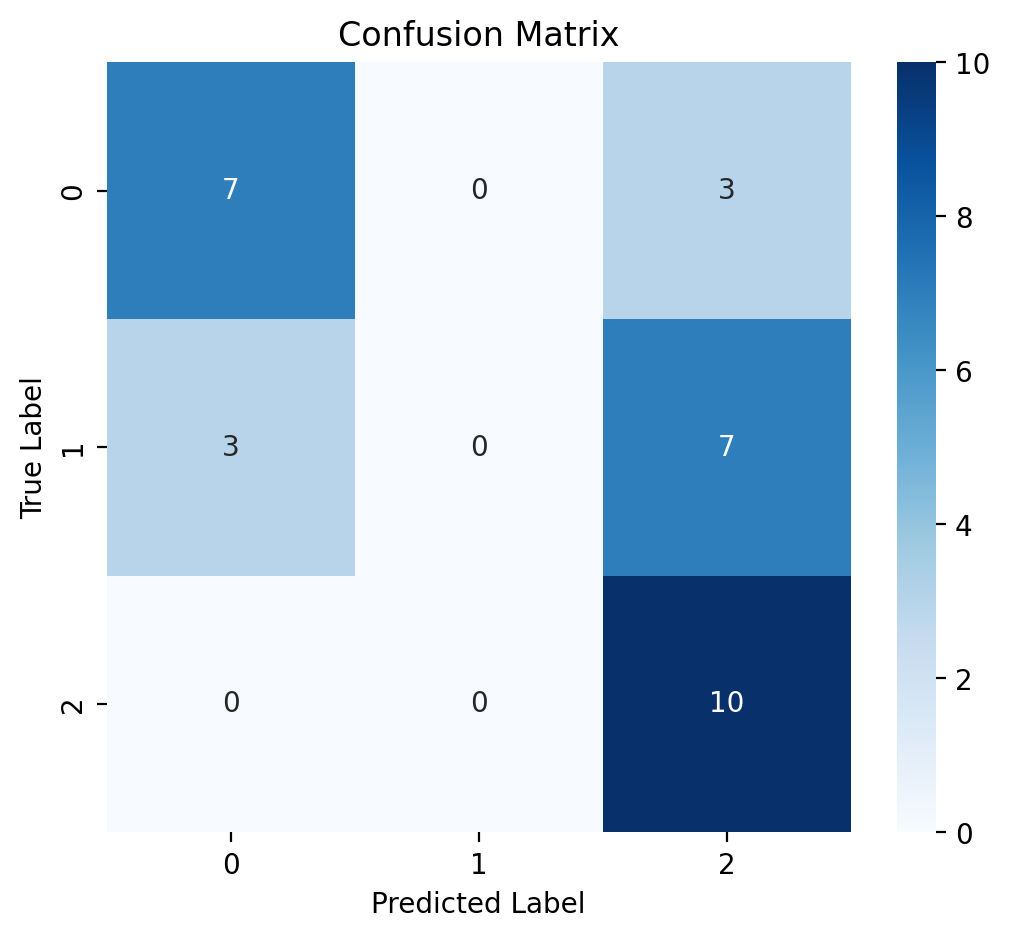

c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.00      0.00      0.00        10
           2       0.50      1.00      0.67        10

    accuracy                           0.57        30
   macro avg       0.40      0.57      0.46        30
weighted avg       0.40      0.57      0.46        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 2
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 1e-05, Epochs: 3
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



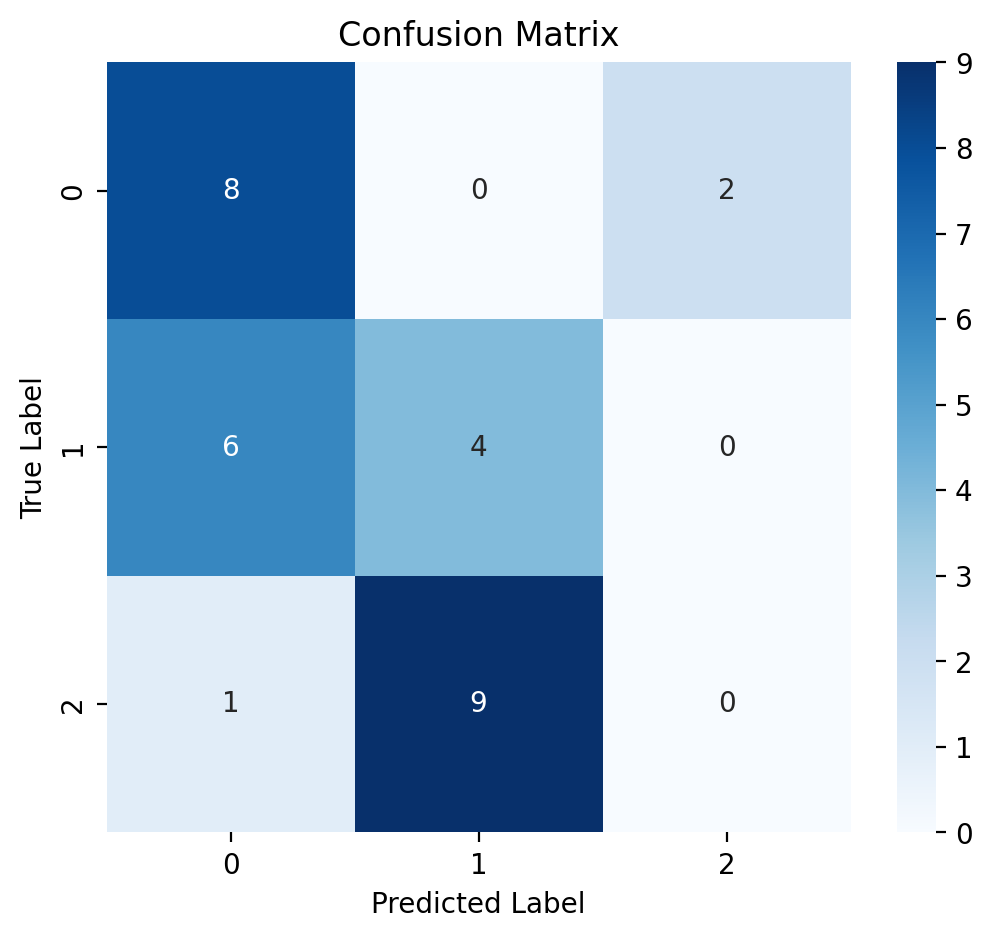

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Model already trained with Batch Size: 4, Learning Rate: 1e-05, Epochs: 5
Evaluating model...
Accuracy: 0.5667, F1 Score: 0.4556



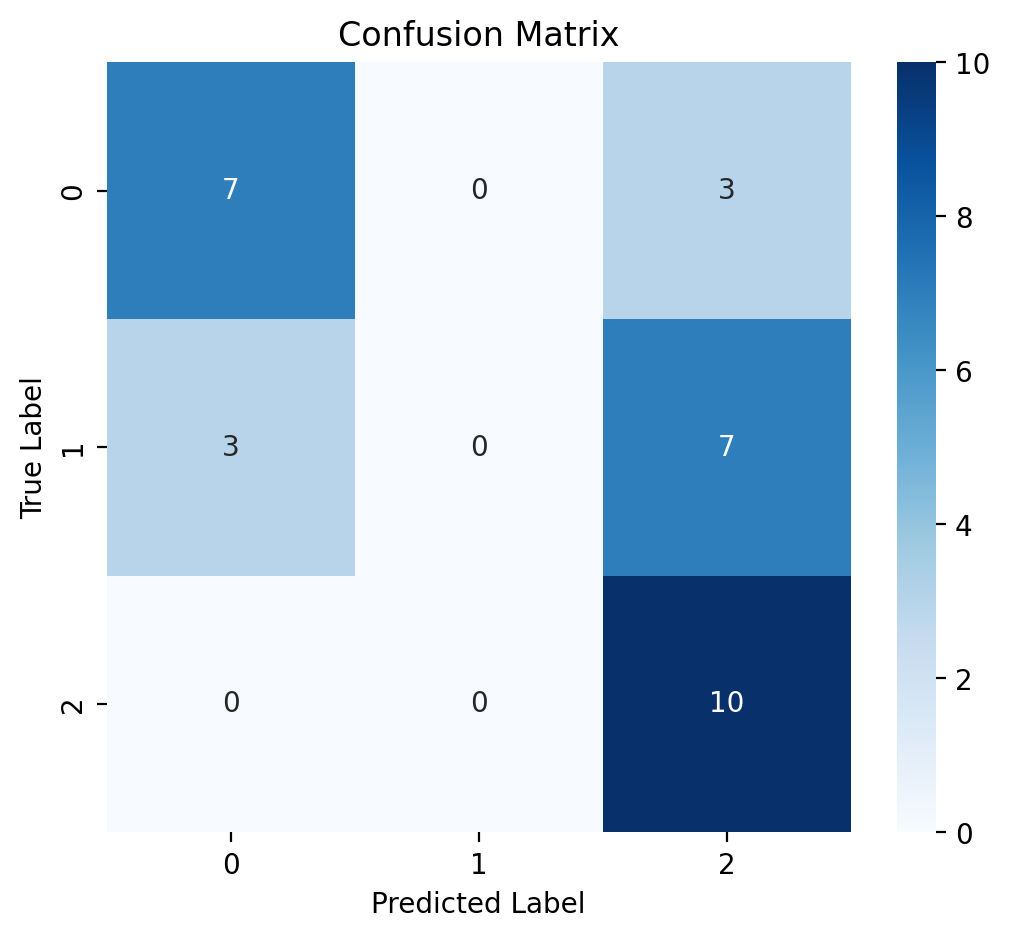

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.00      0.00      0.00        10
           2       0.50      1.00      0.67        10

    accuracy                           0.57        30
   macro avg       0.40      0.57      0.46        30
weighted avg       0.40      0.57      0.46        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 2
--------------------------------------------------


c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [12]:
import os
    
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

predictors = []

predictor_params = {}
   
for batch_size in batch_sizes:
    for lr in learning_rates:
        for epochs in epochs_list:
            # if model is already trained , skip training
            if os.path.exists(f'models/manual_training/bs{batch_size}_lr{lr}_epochs{epochs}/predictor.pkl'):
                print(f"Model already trained with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")
                predictor = TabularPredictor.load(f'models/manual_training/bs{batch_size}_lr{lr}_epochs{epochs}')
                evaluate_model(predictor,test_df)
                predictors.append(predictor)
            else:
                print(f"Training with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")
                predictor = train_manual_mode(train_df,batch_size, lr, epochs)
                evaluate_model(predictor,test_df)
                predictors.append(predictor)
                
            predictor_params[predictor] = {"batch_size": batch_size, "lr": lr, "epochs": epochs}

In [13]:
print(len(predictors))

predictor1 = predictors[2]
predictor1.leaderboard()

12


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L1,0.838095,accuracy,0.031687,9.531535,0.031687,9.531535,1,True,1
1,WeightedEnsemble_L2,0.838095,accuracy,0.032337,9.542147,0.000649,0.010613,2,True,2
2,WeightedEnsemble_L3,0.838095,accuracy,0.032688,9.543598,0.001000,0.012064,3,True,4
3,NeuralNetTorch_BAG_L2,0.819048,accuracy,0.075672,22.749868,0.043985,13.218333,2,True,3


In [14]:
models = predictor1.model_names()
print(models)
model = predictor1._trainer.load_model(models[0])
print(model)
print(model.models)  # Lists the base models inside the ensemble

['NeuralNetTorch_BAG_L1', 'WeightedEnsemble_L2', 'NeuralNetTorch_BAG_L2', 'WeightedEnsemble_L3']
['S1F1', 'S1F2', 'S1F3', 'S1F4', 'S1F5', 'S1F6', 'S1F7', 'S1F8']


In [15]:
import pandas as pd

def compare_leaderboards(predictors):
    """
    Compare AutoGluon predictors using leaderboard performance.
    
    Args:
        predictors (list): List of AutoGluon predictor objects.
    
    Returns:
        None (prints leaderboard comparison)
    """
    leaderboards = []

    for i, predictor in enumerate(predictors):
        lb = predictor.leaderboard(silent=True)
        lb["Predictor"] = f"Predictor_{i+1}"  # Add predictor name column
        leaderboards.append(lb)

    # Combine all leaderboards into one dataframe
    combined_leaderboard = pd.concat(leaderboards).reset_index(drop=True)

    # Sort by validation score in descending order
    combined_leaderboard = combined_leaderboard.sort_values(by="score_val", ascending=False)

    print("\n===== Combined Leaderboard =====")
    display(combined_leaderboard)

    # Best predictor
    best_row = combined_leaderboard.iloc[0]
    print("\nBest Model Across Predictors:")
    print(f"Predictor: {best_row['Predictor']}")
    print(f"Model: {best_row['model']}")
    print(f"Score: {best_row['score_val']:.4f}")

compare_leaderboards(predictors)


===== Combined Leaderboard =====


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,Predictor
8,WeightedEnsemble_L3,0.838095,accuracy,0.032688,9.543598,0.001000,0.012064,3,True,4,Predictor_3
7,WeightedEnsemble_L2,0.838095,accuracy,0.032337,9.542147,0.000649,0.010613,2,True,2,Predictor_3
27,WeightedEnsemble_L3,0.838095,accuracy,0.025003,5.512439,0.000997,0.012028,3,True,4,Predictor_9
26,NeuralNetTorch_BAG_L1,0.838095,accuracy,0.024005,5.500411,0.024005,5.500411,1,True,1,Predictor_9
22,NeuralNetTorch_BAG_L1,0.838095,accuracy,0.046590,7.761035,0.046590,7.761035,1,True,1,Predictor_8
23,WeightedEnsemble_L2,0.838095,accuracy,0.047539,7.776114,0.000949,0.015079,2,True,2,Predictor_8
24,WeightedEnsemble_L3,0.838095,accuracy,0.047589,7.780999,0.000998,0.019964,3,True,4,Predictor_8
28,WeightedEnsemble_L2,0.838095,accuracy,0.025025,5.509420,0.001020,0.009009,2,True,2,Predictor_9
6,NeuralNetTorch_BAG_L1,0.838095,accuracy,0.031687,9.531535,0.031687,9.531535,1,True,1,Predictor_3
9,NeuralNetTorch_BAG_L2,0.819048,accuracy,0.075672,22.749868,0.043985,13.218333,2,True,3,Predictor_3



Best Model Across Predictors:
Predictor: Predictor_3
Model: WeightedEnsemble_L3
Score: 0.8381


In [16]:
print(predictor_params[predictors[2]])

{'batch_size': 2, 'lr': 0.001, 'epochs': 5}


### Auto Mode

In [ ]:
def train_auto_mode(train_data, search_strategy):
    """
    Train model with automated hyperparameter optimization.
    Uses search strategy (Grid Search, Random Search, or Hyperband + Bayesian Optimization).
    """
    model_path = 'models/auto_model'
    
    # Define hyperparameter search space
    search_space = {
        'NN_TORCH': {
            'num_epochs': [5,20,50],       # Vary number of epochs
            'learning_rate': [0.001, 0.01, 0.1],  # Different learning rates
            'batch_size': [16, 32, 64],        # Different batch sizes
            'activation': 'relu',              # Keeping activation fixed
            'optimizer': ['adam']       # Try different optimizers
        }
    }


    predictor = TabularPredictor(
        label='target',  
        problem_type='multiclass',
        verbosity=2,  # Higher verbosity for debugging
        eval_metric='accuracy',  
        path=model_path,
    ).fit(
        train_data=train_data,
        hyperparameter_tune_kwargs={
             'num_trials' = 2,
            'searcher': search_strategy,  # 'grid', 'random', or 'bayesopt'
            'scheduler': 'FIFO'  # Try 'FIFO' or 'local' for different behaviors
        },
        hyperparameters=search_space,
        time_limit=600,
        presets='best_quality',
    )

    return predictor


#### Random Searcher

- Random Searcher is a simple searcher that randomly samples hyperparameters from the search space. It is a good baseline for hyperparameter optimization.

- refer to https://auto.gluon.ai/dev/api/autogluon.searcher.RandomSearcher.html#autogluon.searcher.RandomSearcher


- Hyperparameter optimization (HPO) is the process of finding the best hyperparameters for a model. AutoGluon provides a simple interface to perform HPO with a few lines of code. In this tutorial, we will demonstrate how to use AutoGluon to perform HPO for image classification tasks.

- refer to https://auto.gluon.ai/0.1.0/tutorials/image_prediction/hpo.html

In [30]:
predictor = train_auto_mode(train_df,search_strategy='bayes')
evaluate_model(predictor,test_df)

2025-02-25 16:59:19,791	INFO timeout.py:54 -- Reached timeout of 295.87376901766066 seconds. Stopping all trials.
2025-02-25 16:59:19,844	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/UserFiles/CS203_Lab_06/models/auto_model/models/NeuralNetTorch_BAG_L1' in 0.0230s.
2025-02-25 16:59:20,317	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 17 trial(s):
- 4ffa9246: FileNotFoundError('Could not fetch metrics for 4ffa9246: both result.json and progress.csv were not found at D:/UserFiles/CS203_Lab_06/models/auto_model/models/NeuralNetTorch_BAG_L1/4ffa9246')
- 4369f17e: FileNotFoundError('Could not fetch metrics for 4369f17e: both result.json and progress.csv were not found at D:/UserFiles/CS203_Lab_06/models/auto_model/models/NeuralNetTorch_BAG_L1/4369f17e')
- 90e22fe5: FileNotFoundError('Could not fetch metrics for 90e22fe5: both result.json and progress.csv were not found at D:/UserFiles/CS203_Lab_06/models/auto_model/models/

RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.